In [3]:
from signal_gen.generate_harmonics import generate_dataset
from models.deepclean import DeepCleanAE, FFTDeepCleanAE

import numpy as np
import matplotlib.pyplot as plt
import torch
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim
from torch.utils.data import DataLoader, TensorDataset

In [4]:
sr = 1000   # sample rate (number of points sampled per second)
s = 10   # number of seconds
n = sr * s    # number of total time stamp samples

std_min = 10    
std_max = 30
amp_min = 1
amp_max = 20
num_pulses = 1
std_length = 3

train_size = 1000
eval_size = 100
freq = 1
max_num_harmonics = 10

X_train, Y_train, Y_onehot_train = generate_dataset(train_size, n, s, sr, freq, max_num_harmonics, std_min, std_max, amp_min, amp_max, num_pulses, std_length)
X_eval, Y_eval, Y_onehot_eval = generate_dataset(eval_size, n, s, sr, freq, max_num_harmonics, std_min, std_max, amp_min, amp_max, num_pulses, std_length)


(4500.0, 5500.0)

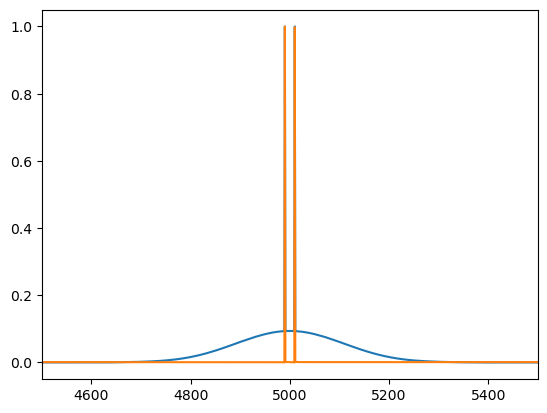

In [5]:
plt.plot(X_train[0].detach().numpy())
plt.plot(Y_train[0].detach().numpy())
plt.xlim(4500,5500)

In [6]:
X_train = X_train.unsqueeze(dim=1).to(torch.float32)
Y_train = Y_train.to(torch.float32)
Y_onehot_train = Y_onehot_train.to(torch.float32)
print(X_train.shape)
print(Y_train.shape)
print(Y_onehot_train.shape)

X_eval = X_eval.unsqueeze(dim=1).to(torch.float32)
Y_eval = Y_eval.to(torch.float32)
Y_onehot_eval = Y_onehot_eval.to(torch.float32)

torch.Size([1000, 1, 10000])
torch.Size([1000, 10000])
torch.Size([1000, 10000])


In [84]:
# dataset generation
batch_size = 64
train_dataset = TensorDataset(X_train, Y_onehot_train)
train_loader = DataLoader(train_dataset, batch_size=batch_size, shuffle=True)

eval_dataset = TensorDataset(X_eval, Y_onehot_eval)
eval_loader = DataLoader(eval_dataset, batch_size=batch_size, shuffle=True)

# Model Instantiation
in_channels = 1
# model = DeepCleanAE(in_channels)
# model.load_state_dict(torch.load("deepclean_model.pth"))

data_for_viz = {}
# training_loss = []
# eval_loss = []
# Loss function and optimizer
lambda_reg = 0.001
# criterion = nn.L1Loss()  # Suitable for classification tasks
criterion = nn.BCEWithLogitsLoss()
optimizer = optim.Adam(model.parameters(), lr=0.001)  # Adam optimizer
 
# Training loop
num_epochs = 200
for epoch in range(num_epochs):
    running_loss = 0.0
    batch = 0
    for inputs, labels in train_loader:
        # Zero the parameter gradients
        optimizer.zero_grad()
        
        # Forward pass
        outputs = model(inputs)
        
        # if batch == 0:
        #     data_for_viz[epoch] = {} # data_for_viz.get(epoch, {})
        #     data_for_viz[epoch]["input"] = inputs.detach().numpy()
        #     data_for_viz[epoch]["input_encoding"] = model.encodings["input_conv"]
        #     for name, _, in list(model.downsampler.named_modules())[1:]:
        #         if "." in name: continue
        #         data_for_viz[epoch][f"downsample_{name}"] = model.encodings[f"downsample_{name}"]
        #     for name, _, in list(model.upsampler.named_modules())[1:]:
        #         if "." in name: continue
        #         data_for_viz[epoch][f"upsample_{name}"] = model.encodings[f"upsample_{name}"]
        #     data_for_viz[epoch]["output_conv"] = model.encodings["output_conv"]
        # batch += 1   
        
        # Compute loss
        loss = criterion(outputs, labels)
        
        l1_norm = sum(p.abs().sum() for p in model.parameters())
        loss += lambda_reg * l1_norm
                
        # Backward pass and optimization
        loss.backward()
        optimizer.step()

        # Accumulate the loss
        running_loss += loss.item()
    training_loss.append(running_loss/len(train_loader))
    
    with torch.no_grad():
        eval_running_loss = 0
        for inputs, labels in eval_loader:
            outputs = model(inputs)
            loss = criterion(outputs, labels)
            l1_norm = sum(p.abs().sum() for p in model.parameters())
            loss += lambda_reg * l1_norm
            eval_running_loss += loss.item()
    eval_loss.append(eval_running_loss/len(eval_loader))
    
    # Print loss at the end of each epoch
    print(f'Epoch [{epoch+1}/{num_epochs}], Train Loss: {running_loss/len(train_loader):.10f}, Eval Loss: {eval_running_loss/len(eval_loader):.10f}')

Epoch [1/200], Train Loss: 0.0287239789, Eval Loss: 0.0268747006
Epoch [2/200], Train Loss: 0.0235752029, Eval Loss: 0.0225357926
Epoch [3/200], Train Loss: 0.0216210434, Eval Loss: 0.0206250269
Epoch [4/200], Train Loss: 0.0214225849, Eval Loss: 0.0203734897
Epoch [5/200], Train Loss: 0.0210389999, Eval Loss: 0.0206893831
Epoch [6/200], Train Loss: 0.0211269333, Eval Loss: 0.0207437053
Epoch [7/200], Train Loss: 0.0209680093, Eval Loss: 0.0207890673
Epoch [8/200], Train Loss: 0.0206282879, Eval Loss: 0.0224574236
Epoch [9/200], Train Loss: 0.0206972894, Eval Loss: 0.0213195980
Epoch [10/200], Train Loss: 0.0206778934, Eval Loss: 0.0215819059
Epoch [11/200], Train Loss: 0.0206198009, Eval Loss: 0.0210922686
Epoch [12/200], Train Loss: 0.0206991492, Eval Loss: 0.0206053946
Epoch [13/200], Train Loss: 0.0206476442, Eval Loss: 0.0193794165
Epoch [14/200], Train Loss: 0.0207024588, Eval Loss: 0.0200487012
Epoch [15/200], Train Loss: 0.0205150368, Eval Loss: 0.0204320764
Epoch [16/200], Tra

KeyboardInterrupt: 

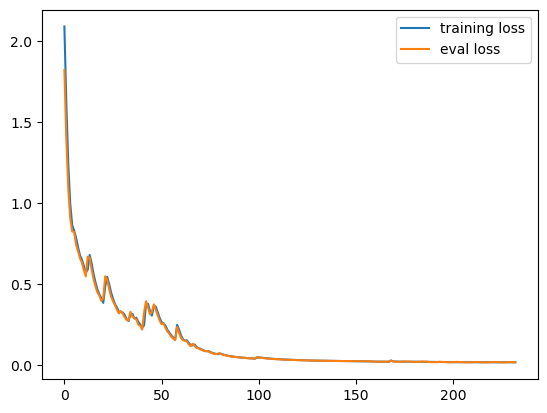

In [85]:
plt.plot(training_loss, label="training loss")
plt.plot(eval_loss, label="eval loss")
plt.legend()
plt.show()

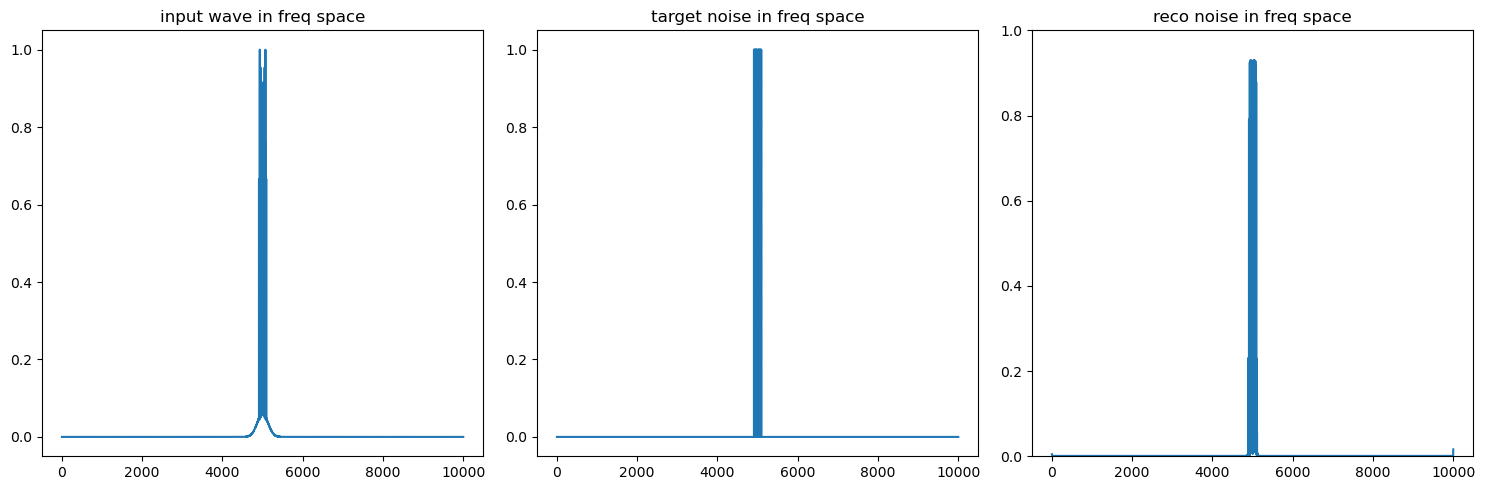

In [90]:
i = 35
# plt.plot(inputs.squeeze(dim=1)[i].detach().numpy())
# plt.show()
# plt.plot(labels[i].detach().numpy())
# plt.show()
# plt.plot(torch.sigmoid(outputs[i]).detach().numpy())
# plt.ylim(0,1)

import matplotlib.pyplot as plt
import numpy as np

# Create a figure and an array of 3 subplots arranged in a row
fig, axs = plt.subplots(1, 3, figsize=(15, 5))  # 1 row, 3 columns

# Plot 1: Sine wave
axs[0].plot(inputs.squeeze(dim=1)[i].detach().numpy())
axs[0].set_title('input wave in freq space')

# Plot 2: Cosine wave
axs[1].plot(labels[i].detach().numpy())
axs[1].set_title('target noise in freq space')

# Plot 3: Tangent wave
axs[2].plot(torch.sigmoid(outputs[i]).detach().numpy())
axs[2].set_title('reco noise in freq space')
axs[2].set_ylim(0, 1)  # Limit y-axis for tangent plot

# Adjust spacing between plots
plt.tight_layout()

# Show the plot
plt.show()



In [87]:
prob_pred = torch.sigmoid(outputs[i])
lab = labels[i]

In [88]:
torch.where(prob_pred > 0.6)

(tensor([4910, 4930, 4940, 4950, 4960, 4970, 4980, 4990, 5000, 5010, 5020, 5030,
         5040, 5050, 5060, 5070, 5080, 5090]),)

In [89]:
torch.where(lab > 0.1)

(tensor([4910, 4920, 4930, 4940, 4950, 4960, 4970, 4980, 4990, 5010, 5020, 5030,
         5040, 5050, 5060, 5070, 5080, 5090]),)

In [97]:
# dataset generation
batch_size = 64
train_dataset = TensorDataset(X_train, Y_onehot_train)
train_loader = DataLoader(train_dataset, batch_size=batch_size, shuffle=True)

eval_dataset = TensorDataset(X_eval, Y_onehot_eval)
eval_loader = DataLoader(eval_dataset, batch_size=batch_size, shuffle=True)

# Model Instantiation
in_channels = 1
model2 = DeepCleanAE(in_channels)
# model.load_state_dict(torch.load("deepclean_model.pth"))

data_for_viz = {}
training_loss2 = []
eval_loss2 = []
# Loss function and optimizer
lambda_reg = 0.001
criterion = nn.L1Loss()  # MAE loss
# criterion = nn.BCEWithLogitsLoss()
optimizer = optim.Adam(model2.parameters(), lr=0.001)  # Adam optimizer

# Training loop
num_epochs = 100
for epoch in range(num_epochs):
    running_loss = 0.0
    batch = 0
    for inputs, labels in train_loader:
        # Zero the parameter gradients
        optimizer.zero_grad()
        
        # Forward pass
        outputs = model2(inputs)
        
        # Compute loss
        loss = criterion(outputs, labels)
        
        # l1_norm = sum(p.abs().sum() for p in model2.parameters())
        # loss += lambda_reg * l1_norm
                
        # Backward pass and optimization
        loss.backward()
        optimizer.step()

        # Accumulate the loss
        running_loss += loss.item()
    training_loss2.append(running_loss/len(train_loader))
    
    with torch.no_grad():
        eval_running_loss = 0
        for inputs, labels in eval_loader:
            outputs = model2(inputs)
            loss = criterion(outputs, labels)
            eval_running_loss += loss.item()
    eval_loss2.append(eval_running_loss/len(eval_loader))
    
    # Print loss at the end of each epoch
    print(f'Epoch [{epoch+1}/{num_epochs}], Train Loss: {running_loss/len(train_loader):.10f}, Eval Loss: {eval_running_loss/len(eval_loader):.10f}')

Epoch [1/100], Train Loss: 0.0063608078, Eval Loss: 0.0038827471
Epoch [2/100], Train Loss: 0.0031510621, Eval Loss: 0.0029255576
Epoch [3/100], Train Loss: 0.0027876168, Eval Loss: 0.0024202199
Epoch [4/100], Train Loss: 0.0022668490, Eval Loss: 0.0025439017
Epoch [5/100], Train Loss: 0.0024830247, Eval Loss: 0.0027701694
Epoch [6/100], Train Loss: 0.0024666200, Eval Loss: 0.0024042646
Epoch [7/100], Train Loss: 0.0024550664, Eval Loss: 0.0026736605
Epoch [8/100], Train Loss: 0.0023319493, Eval Loss: 0.0024899525
Epoch [9/100], Train Loss: 0.0025685354, Eval Loss: 0.0026042769
Epoch [10/100], Train Loss: 0.0028578422, Eval Loss: 0.0027821300
Epoch [11/100], Train Loss: 0.0023033265, Eval Loss: 0.0022933042
Epoch [12/100], Train Loss: 0.0023524940, Eval Loss: 0.0025116939
Epoch [13/100], Train Loss: 0.0025603750, Eval Loss: 0.0032640668
Epoch [14/100], Train Loss: 0.0025034276, Eval Loss: 0.0023092137
Epoch [15/100], Train Loss: 0.0022123919, Eval Loss: 0.0026377776
Epoch [16/100], Tra

KeyboardInterrupt: 

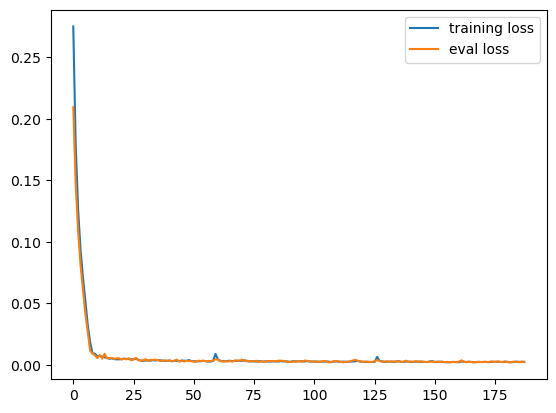

In [98]:
plt.plot(training_loss2, label="training loss")
plt.plot(eval_loss2, label="eval loss")
plt.legend()
plt.show()

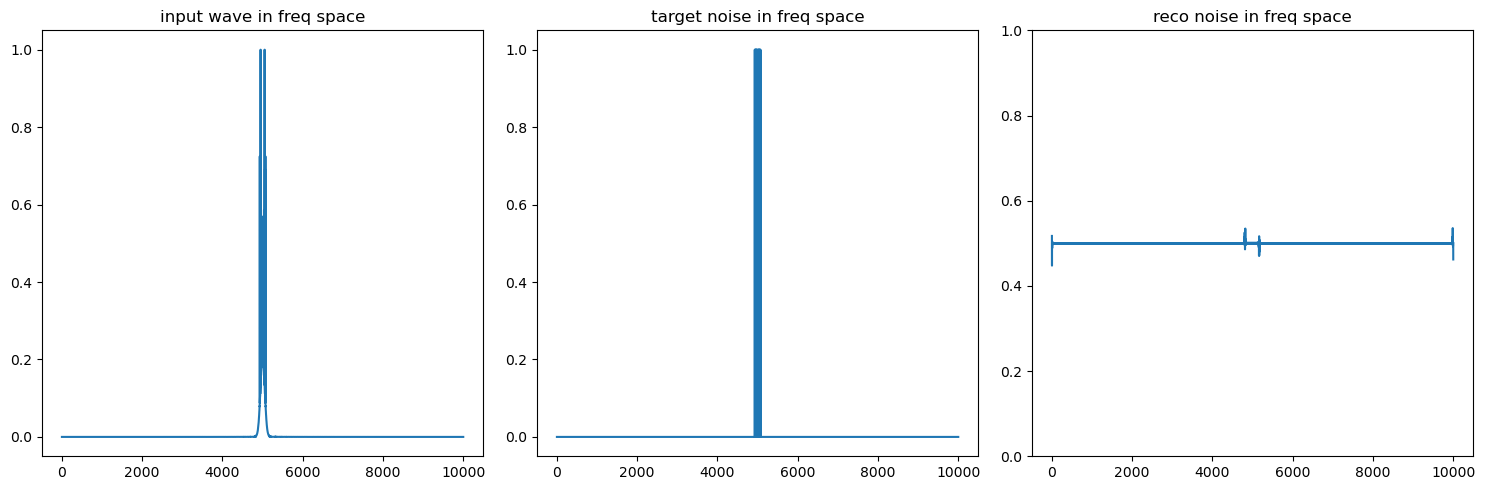

In [99]:
i = 35
# plt.plot(inputs.squeeze(dim=1)[i].detach().numpy())
# plt.show()
# plt.plot(labels[i].detach().numpy())
# plt.show()
# plt.plot(torch.sigmoid(outputs[i]).detach().numpy())
# plt.ylim(0,1)

import matplotlib.pyplot as plt
import numpy as np

# Create a figure and an array of 3 subplots arranged in a row
fig, axs = plt.subplots(1, 3, figsize=(15, 5))  # 1 row, 3 columns

# Plot 1: Sine wave
axs[0].plot(inputs.squeeze(dim=1)[i].detach().numpy())
axs[0].set_title('input wave in freq space')

# Plot 2: Cosine wave
axs[1].plot(labels[i].detach().numpy())
axs[1].set_title('target noise in freq space')

# Plot 3: Tangent wave
axs[2].plot(torch.sigmoid(outputs[i]).detach().numpy())
axs[2].set_title('reco noise in freq space')
axs[2].set_ylim(0, 1)  # Limit y-axis for tangent plot

# Adjust spacing between plots
plt.tight_layout()

# Show the plot
plt.show()



In [1]:
model

NameError: name 'model' is not defined